# Investment model dispatch patterns
Routines for analyzing dispatch patterns of *pommesinvest* runs

## Package imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pommesevaluation.investment_results_inspection import (
    preprocess_raw_results, aggregate_investment_results, plot_single_dispatch_pattern
)

## Parameters and workflow settings

In [20]:
# Model configuration
time_frame_in_years = 26
frequency = "1H"
dr_scenario = "50"
dr_scenarios = ["none", "5", "50", "95"]
fuel_price_scenario = "NZE"
emissions_pathway = "long-term"
multi_header = False
countries = [
    "AT",
    "BE",
    "CH",
    "CZ",
    "DE",
    "DK1",
    "DK2",
    "FR",
    "NL",
    "NO1",
    "NO2",
    "NO3",
    "NO4",
    "NO5",
    "PL",
    "SE1",
    "SE2",
    "SE3",
    "SE4",
    "IT",
]
impose_investment_maxima = False

# Paths, filenames and color codes
path_results = "./model_results/pommesinvest/"
path_processed_data = "./data_out/"
path_plots = "./plots/"

filename = (
    f"investment_LP_start-2020-01-01_{time_frame_in_years}"
    f"-years_simple_freq_{frequency}"
)
if impose_investment_maxima:
    annual_investment_limits = ""
else:
    annual_investment_limits = "_no_annual_limit"
if dr_scenario != "none":
    file_add_on = (
        f"_with_dr_{dr_scenario}_"
        f"fuel_price-{fuel_price_scenario}_"
        f"co2_price-{emissions_pathway}{annual_investment_limits}_production"
    )
else:
    file_add_on = (
        f"_no_dr_50_"
        f"fuel_price-{fuel_price_scenario}_"
        f"co2_price-{emissions_pathway}{annual_investment_limits}_production"
    )
file_extension = ".csv"

filenames_out = {
    "shortages_artificial": {
        dr_scenario: f"{path_processed_data}sources_el_artificial_{dr_scenario}.csv"
        for dr_scenario in dr_scenarios
    },
    "shortages_artificial_ts": {
        dr_scenario: f"{path_processed_data}sources_el_artificial_ts_{dr_scenario}.csv"
        for dr_scenario in dr_scenarios
    }
}

# color codes
FUELS_EXISTING = {
    "uranium": "#e50000",
    "lignite": "#7f2b0a",
    "hardcoal": "#000000",
    "mixedfuels": "#a57e52",
    "otherfossil": "#d8dcd6",
}

FUELS = {
    "biomass": "#15b01a",
    "hydrogen": "#6fa8dc",
    "natgas": "#ffd966",
    "oil": "#aaa662",
    "waste": "#c04e01"
}

RES_SOURCES = {
    "DE_source_ROR": "#c79fef",
    "DE_source_biomassEEG": "#15b01a",
    "DE_source_geothermal": "#cccccc",
    "DE_source_landfillgas": "#cccccc",
    "DE_source_larga": "#cccccc",
    "DE_source_minegas": "#cccccc",
    "DE_source_solarPV": "#fcb001",
    "DE_source_windoffshore": "#0504aa",
    "DE_source_windonshore": "#82cafc",
}

DEMAND_RESPONSE_CLUSTERS = {
    "hoho_cluster_shift_only": "#333333", 
    "hoho_cluster_shift_shed": "#555555", 
    "ind_cluster_shed_only": "#666666",
    "ind_cluster_shift_only": "#888888", 
    "ind_cluster_shift_shed": "#aaaaaa", 
    "tcs+hoho_cluster_shift_only": "pink", # "#cccccc",
    "tcs_cluster_shift_only": "orange" # "#dddddd", 
}

STORAGES = {
    "PHS": "#0c2aac",
    "PHS_new_built": "#7c90e7",
    "battery": "#f7e09a",
    "battery_new_built": "#fff5d5",
}

LOAD = {
    "DE_sink_el_load": "darkblue"
}

EVS = {
    "DE_bus_ev_cc_bidirectional": "#7E7B2D",
    "DE_bus_ev_cc_unidirectional": "#989336", 
    "DE_bus_ev_uc": "#B1AC3F",
}

SHORTAGE_EXCESS = {
    "DE_sink_el_excess": "purple",
    "DE_source_el_shortage": "red",
}

# Workflow and output configuration
plt.rcParams.update({'font.size': 12})
rounding_precision = 2

start_time_step = "2037-03-03 00:00:00"
time_steps_to_be_considered_in_hours = 168 * 12
amount_of_time_steps = time_steps_to_be_considered_in_hours / int(frequency.split("H")[0])

# Single scenario analyses
Inspect the results for a single scenario model run.
## Read in, preprocess and aggregate data
* Use routine originally developped for investment model to preprocess raw results. Therefore, transpose back and forth.
* Aggregate by fuel. Don't aggregate storages, demand response etc.
* Form distinct data sets:
    * Demand: regular load without demand response baseline consumption and demand response net load
    * Exports and imports: exports from DE to European neighbours, imports vice versa
    * Storages: inflow, outflow and net storage usage derived from these
    * Generators: generation aggregated per fuel
    * Demand Response: upshifts, downshifts and demand response storage level
    * Shortage and excess

In [3]:
if multi_header:
    header = [0, 1]
else:
    header = 0
production_results_raw = pd.read_csv(
    f"{path_results}{filename}{file_add_on}{file_extension}", index_col=0, header=header
).T
processed_results = preprocess_raw_results(
    production_results_raw, investments=False, multi_header=multi_header
).drop(columns="year").round(rounding_precision)
aggregated_results = aggregate_investment_results(
    processed_results, energy_carriers={**FUELS_EXISTING, **FUELS}, by="energy_carrier", investments=False
).T
del production_results_raw, processed_results

In [4]:
# Define cols to group
demand_cols = [col for col in aggregated_results.columns if "DE_sink_el" in col and "_excess" not in col]
export_link_cols = [col for col in aggregated_results.columns if "DE_link" in col]
import_link_cols = [col for col in aggregated_results.columns if "link_DE" in col]
power_prices_col = ["DE_bus_el"]

all_demand_response_cols = list(set([
    col for col in aggregated_results.columns for key in DEMAND_RESPONSE_CLUSTERS if key in col
]))

demand_response_after_cols = [col for col in all_demand_response_cols if "_demand_after" in col]
demand_cols.extend(demand_response_after_cols)

demand_response_other_cols = [
    col for col in all_demand_response_cols 
    if col not in demand_response_after_cols
    # Exclude fictious demand response storage level which can be calculated ex post
    and not "storage_level" in col
]

storages_cols = list(set([
    col for col in aggregated_results.columns 
    for key in STORAGES if key in col
    and "inflow" in col or "outflow" in col
]))
shortage_excess_cols = [
    col for col in aggregated_results.columns if col in ["DE_sink_el_excess", "DE_source_el_shortage"]
]
electrolyzer_cols = [col for col in aggregated_results.columns if "electrolyzer" in col]
foreign_country_cols = list(
    set([
        col for col in aggregated_results.columns for country in countries
        if f"{country}_" in col and country != "DE"
    ])
)

generators_cols = [
    col for col in aggregated_results.columns 
    if col not in demand_cols 
    and col not in export_link_cols
    and col not in import_link_cols
    and col not in all_demand_response_cols 
    and col not in storages_cols
    and col not in shortage_excess_cols
    and col not in electrolyzer_cols
    and col not in power_prices_col
    and col not in foreign_country_cols
]

# Split overall data set to distinct subsets
demand_pattern = aggregated_results[demand_cols]
export_pattern = aggregated_results[export_link_cols]
import_pattern = aggregated_results[import_link_cols]
demand_response_pattern = aggregated_results[demand_response_other_cols]
storages_pattern = aggregated_results[storages_cols]
shortage_excess_pattern = aggregated_results[shortage_excess_cols]
generators_pattern = aggregated_results[generators_cols]
power_prices_pattern = aggregated_results[power_prices_col]

# Slightly alter / negate
storages_pattern.loc[:, [col for col in storages_pattern.columns if "_outflow" in col]] *= (-1)
shortage_excess_pattern.loc[:, "DE_source_el_shortage"] *= (-1)
demand_response_pattern.loc[: , [col for col in demand_response_pattern.columns if "dsm_do" in col]] *= (-1)

C:\Users\koch_j0\AppData\Local\Temp\ipykernel_13024\79101515.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storages_pattern.loc[:, [col for col in storages_pattern.columns if "_outflow" in col]] *= (-1)
C:\Users\koch_j0\AppData\Local\Temp\ipykernel_13024\79101515.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shortage_excess_pattern.loc[:, "DE_source_el_shortage"] *= (-1)
C:\Users\koch_j0\AppData\Local\Temp\ipykernel_13024\79101515.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

In [5]:
generators_pattern.sum()

energy_carrier
DE_bus_ev_cc_bidirectional                  5.341804e+08
DE_bus_ev_cc_unidirectional                 4.085621e+08
DE_bus_ev_uc                                4.696934e+08
DE_source_ROR                               1.719453e+08
DE_source_biomassEEG                        6.775667e+08
DE_source_geothermal                        5.100794e+06
DE_source_landfillgas                       2.342419e+07
DE_source_larga                             1.182052e+07
DE_source_minegas                           2.475900e+07
DE_source_solarPV                           4.448643e+09
DE_source_windoffshore                      1.844933e+09
DE_source_windonshore                       5.205725e+09
biomass                                     5.746344e+08
hardcoal                                    1.539514e+08
hydrogen                                    6.218078e+08
lignite                                     7.006593e+08
mixedfuels                                  9.880585e+04
natgas          

## Inspect some long-term results
* Exports and imports patterns
* Demand

### Exports and imports

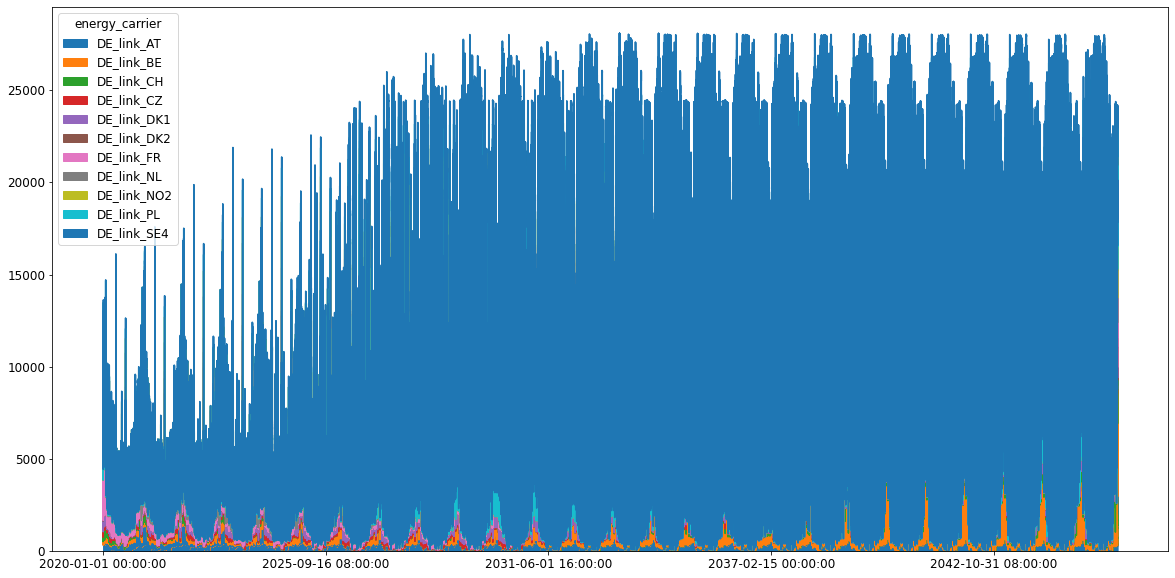

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
export_pattern.plot(kind="area", stacked=True, ax=ax)
plt.show()

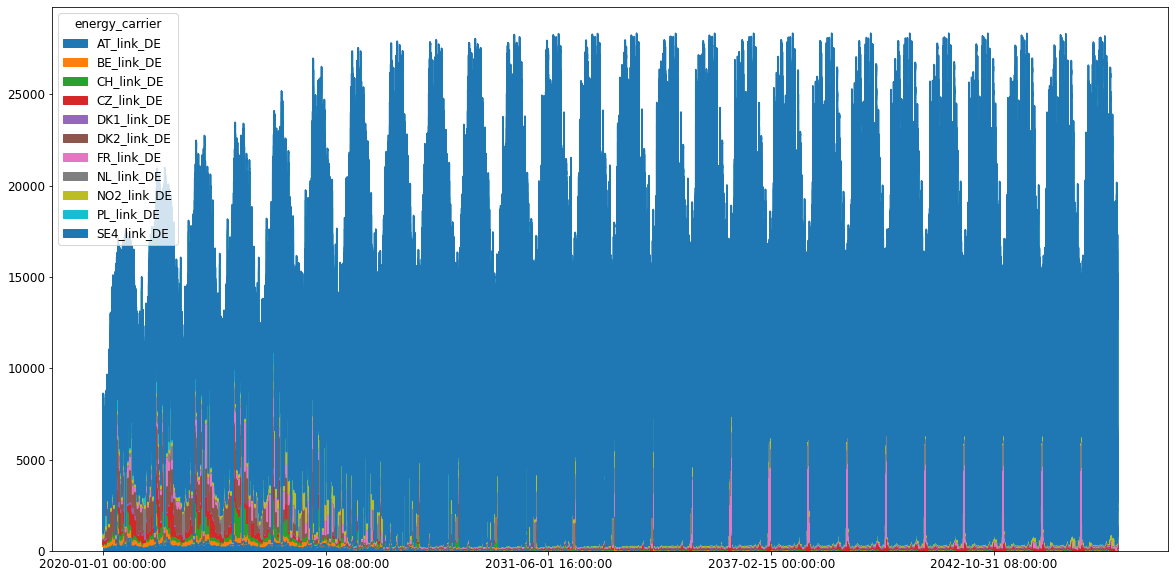

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
import_pattern.plot(kind="area", stacked=True, ax=ax)
plt.show()

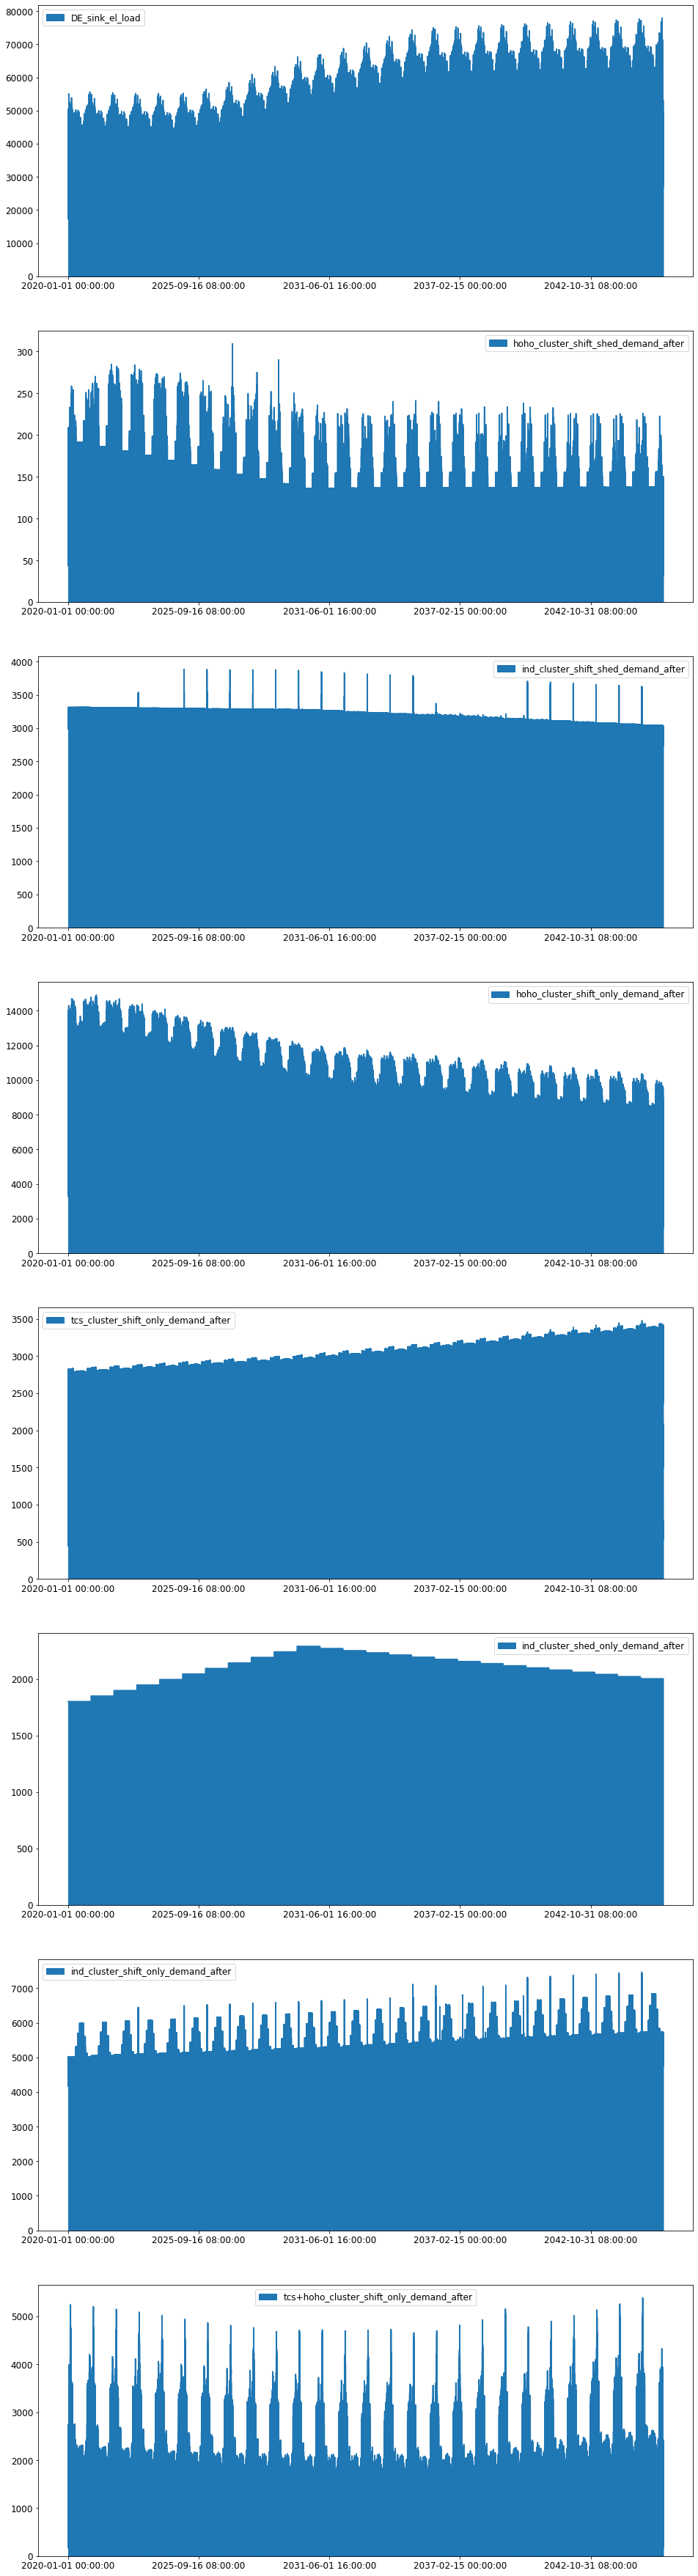

In [8]:
if dr_scenario != "none":
    fig, ax = plt.subplots(len(demand_pattern.columns), figsize=(16, 8 * len(demand_pattern.columns)))
    for i, col in enumerate(demand_pattern.columns):
        demand_pattern[col].plot(kind="area", stacked=True, ax=ax[i])
        ax[i].legend(loc="best")
    plt.show()

else:
    fig, ax = plt.subplots(figsize=(16, 8))
    demand_pattern.plot(kind="area", ax=ax)
    plt.show()                           

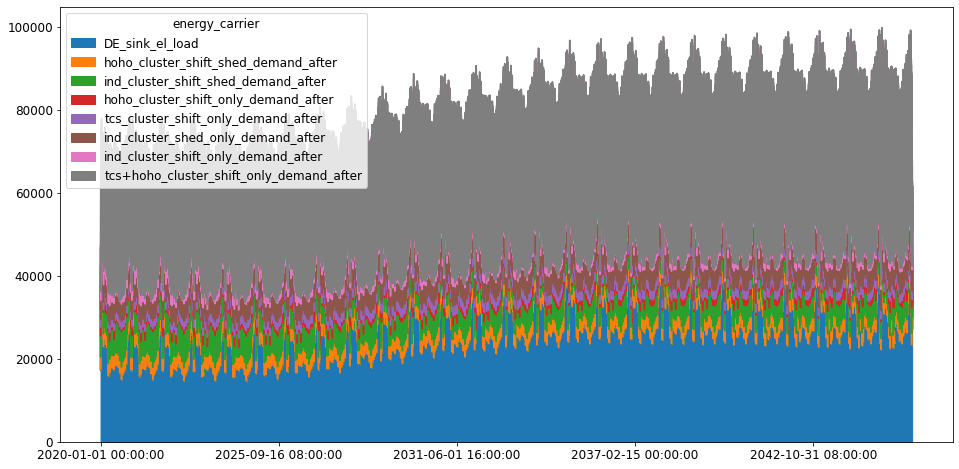

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))
demand_pattern.plot(kind="area", stacked=True, ax=ax)
plt.show()

In [10]:
demand_pattern.max()

energy_carrier
DE_sink_el_load                             77938.97
hoho_cluster_shift_shed_demand_after          309.56
ind_cluster_shift_shed_demand_after          3885.37
hoho_cluster_shift_only_demand_after        14917.59
tcs_cluster_shift_only_demand_after          3477.71
ind_cluster_shed_only_demand_after           2289.75
ind_cluster_shift_only_demand_after          7472.65
tcs+hoho_cluster_shift_only_demand_after     5392.32
dtype: float64

## Create simple dispatch plots
### Demand and generation
Create simple area plots

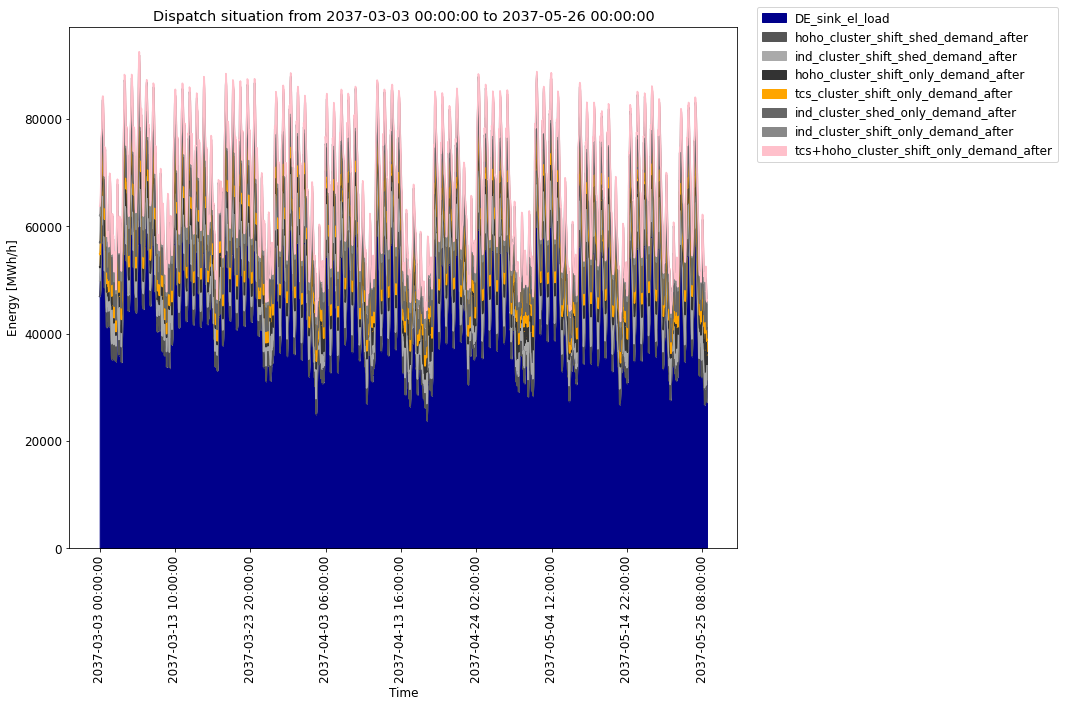

In [11]:
colors = {
    **LOAD, 
    **{
        f"{cluster}_demand_after": value for cluster, value in DEMAND_RESPONSE_CLUSTERS.items()
    }
}

plot_single_dispatch_pattern(
    demand_pattern,
    start_time_step,
    amount_of_time_steps,
    colors,
    save=True,
    path_plots="./plots/",
    filename="demand_pattern",
)

In [12]:
demand_pattern.describe()

energy_carrier,DE_sink_el_load,hoho_cluster_shift_shed_demand_after,ind_cluster_shift_shed_demand_after,hoho_cluster_shift_only_demand_after,tcs_cluster_shift_only_demand_after,ind_cluster_shed_only_demand_after,ind_cluster_shift_only_demand_after,tcs+hoho_cluster_shift_only_demand_after
count,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000
mean,42505.298055,91.997192,3048.930791,6404.607323,2238.348019,2095.461730,5175.796971,1022.500424
std,11499.242369,44.591151,182.932571,2770.232392,810.577046,138.286577,482.141904,776.478762
min,14557.750000,0.380000,1217.020000,303.940000,444.360000,704.980000,2094.750000,1.200000
25%,33596.480000,49.320000,2913.470000,3976.607500,1752.282500,2021.900000,4818.982500,494.960000
50%,41649.725000,96.980000,2991.800000,6747.915000,2449.110000,2098.750000,5119.820000,814.045000
75%,50464.120000,123.952500,3226.240000,8349.230000,2848.240000,2193.730000,5451.910000,1290.260000
max,77938.970000,309.560000,3885.370000,14917.590000,3477.710000,2289.750000,7472.650000,5392.320000


In [13]:
generators_pattern.describe()

energy_carrier,DE_bus_ev_cc_bidirectional,DE_bus_ev_cc_unidirectional,DE_bus_ev_uc,DE_source_ROR,DE_source_biomassEEG,DE_source_geothermal,DE_source_landfillgas,DE_source_larga,DE_source_minegas,DE_source_solarPV,...,mixedfuels,natgas,oil,otherfossil,storage_ev_cc_bidirectional,storage_ev_cc_unidirectional,transformer_ev_cc_bidirectional_feedback,transformer_ev_uc,uranium,waste
count,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,...,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000,227760.000000
mean,2345.365424,1793.827471,2062.229574,754.940623,2974.915233,22.395479,102.845918,51.899014,108.706548,19532.151617,...,0.433816,3465.566054,389.428781,518.849240,2345.365433,1793.827471,551.537953,2062.229574,578.439842,643.560363
std,2417.563053,1821.703866,1940.351036,138.179330,72.319291,1.300195,11.634822,1.866150,16.075245,35009.846972,...,1.080852,7892.661784,1506.264127,864.917162,2417.563110,1821.703866,1555.164122,1940.351036,1840.156545,719.681979
min,8.660000,4.960000,12.060000,416.220000,2829.270000,19.920000,76.600000,49.300000,81.840000,0.000000,...,0.000000,0.000000,0.000000,0.000000,8.660000,4.960000,1.080000,12.060000,0.000000,0.000000
25%,428.650000,295.985000,563.435000,661.050000,2938.200000,21.870000,98.490000,49.950000,85.880000,0.000000,...,0.000000,36.387500,2.660000,2.000000,428.650000,295.985000,5.240000,563.435000,0.000000,3.680000
50%,1542.350000,1141.615000,1434.605000,790.940000,2952.600000,22.010000,104.680000,51.180000,114.100000,421.635000,...,0.340000,587.675000,9.650000,17.550000,1542.350000,1141.615000,16.160000,1434.605000,0.000000,23.570000
75%,3595.887500,2837.125000,2987.795000,865.100000,3015.900000,23.120000,112.030000,53.420000,118.680000,23352.182500,...,0.580000,1483.370000,27.580000,686.092500,3595.897500,2837.125000,83.692500,2987.795000,0.000000,1466.620000
max,15373.640000,8329.940000,9314.340000,973.790000,3100.840000,24.710000,116.630000,54.590000,128.770000,210628.220000,...,18.850000,42560.720000,8724.790000,2585.610000,15373.640000,8329.940000,10921.420000,9314.340000,8112.110000,1552.920000


In [14]:
generators_pattern["mixedfuels"].max()

18.85

In [15]:
start_time_step="2037-03-03 16:00:00"
amount_of_time_steps=168 * 2

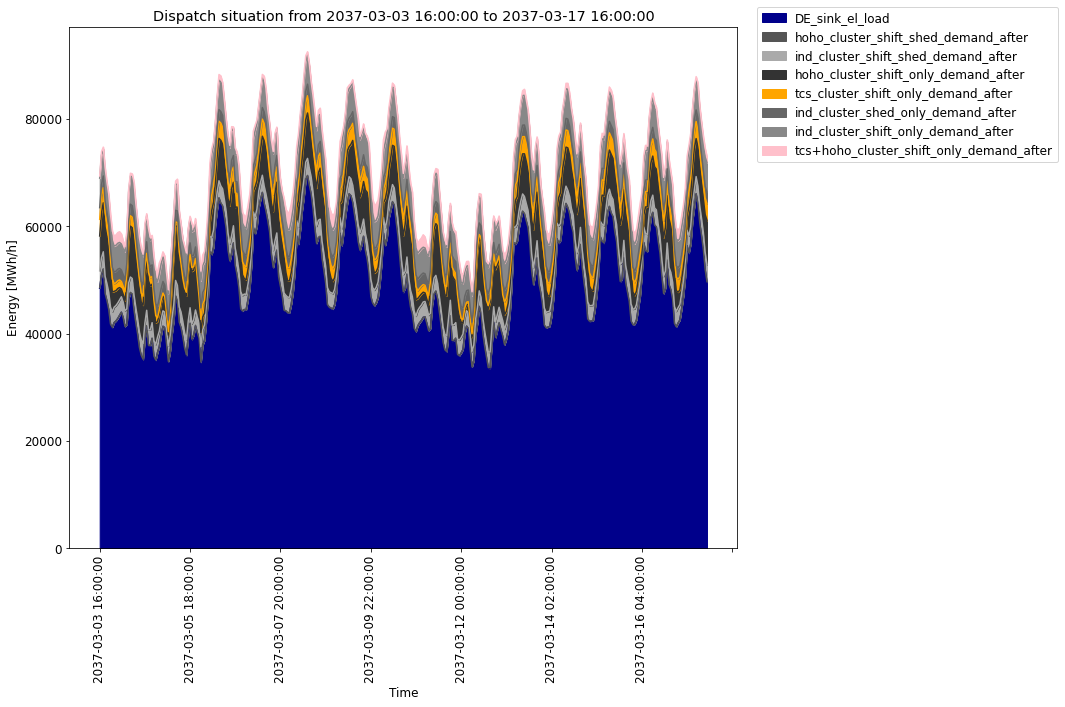

In [16]:
colors = {
    **LOAD, 
    **{
        f"{cluster}_demand_after": value for cluster, value in DEMAND_RESPONSE_CLUSTERS.items()
    }
}

plot_single_dispatch_pattern(
    demand_pattern,
    start_time_step,
    amount_of_time_steps,
    colors,
    save=True,
    path_plots="./plots/",
    filename="demand_pattern",
)

In [18]:
generators_pattern

energy_carrier,DE_bus_ev_cc_bidirectional,DE_bus_ev_cc_unidirectional,DE_bus_ev_uc,DE_source_ROR,DE_source_biomassEEG,DE_source_geothermal,DE_source_landfillgas,DE_source_larga,DE_source_minegas,DE_source_solarPV,...,mixedfuels,natgas,oil,otherfossil,storage_ev_cc_bidirectional,storage_ev_cc_unidirectional,transformer_ev_cc_bidirectional_feedback,transformer_ev_uc,uranium,waste
2020-01-01 00:00:00,253.71,8.62,106.19,496.55,2829.27,23.82,98.49,54.59,123.02,0.0,...,0.92,3967.20,156.95,874.95,253.72,8.62,245.09,106.19,4072.15,85.27
2020-01-01 01:00:00,246.97,6.40,68.04,496.44,2829.27,23.82,98.49,54.59,123.02,0.0,...,0.92,3946.82,157.19,874.82,246.97,6.40,240.57,68.04,4073.43,84.83
2020-01-01 02:00:00,235.43,5.15,43.26,495.78,2829.27,23.82,98.49,54.59,123.02,0.0,...,0.91,3941.46,156.97,874.52,235.43,5.15,230.28,43.26,4071.95,82.81
2020-01-01 03:00:00,231.09,4.96,27.40,488.94,2829.27,23.82,98.49,54.59,123.02,0.0,...,0.91,3940.73,156.87,874.28,231.10,4.96,226.13,27.40,4071.56,82.31
2020-01-01 04:00:00,240.40,16.38,16.96,487.71,2829.27,23.82,98.49,54.59,123.02,0.0,...,0.91,3939.81,156.77,874.06,240.40,16.38,224.02,16.96,4071.24,82.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045-12-31 19:00:00,4318.65,3973.90,9314.34,814.78,2894.17,21.94,99.50,53.68,128.00,0.0,...,0.00,0.00,0.00,0.00,4318.65,3973.90,344.75,9314.34,0.00,0.00
2045-12-31 20:00:00,2823.59,2463.71,8997.89,810.70,2894.17,21.94,99.50,53.68,128.00,0.0,...,0.00,0.00,0.00,0.00,2823.59,2463.71,359.88,8997.89,0.00,0.00
2045-12-31 21:00:00,2058.36,1686.57,7679.86,802.98,2894.17,21.94,99.50,53.68,128.00,0.0,...,0.00,0.00,0.00,0.00,2058.35,1686.57,371.79,7679.86,0.00,0.00
2045-12-31 22:00:00,1987.03,1607.57,6318.53,799.11,2894.17,21.94,99.50,53.68,128.00,0.0,...,0.00,0.00,0.00,0.00,1987.03,1607.57,379.46,6318.53,0.00,0.00


KeyError: 'DE_bus_ev_cc_bidirectional'

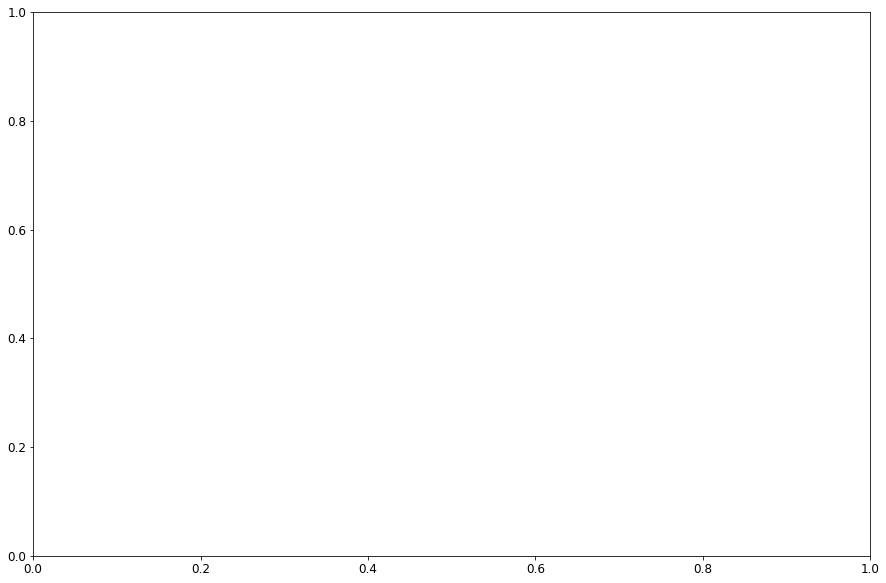

In [17]:
colors = {
    **FUELS_EXISTING, 
    **FUELS,
    **RES_SOURCES,
    **EVS,
}

plot_single_dispatch_pattern(
    generators_pattern,
    start_time_step,
    amount_of_time_steps,
    colors,
    save=True,
    path_plots="./plots/",
    filename="generation_pattern",
)

### Storages, Demand Response, Shortage and excess
Area plots, but change in sign

In [ ]:
shortage_excess_pattern.describe()

In [ ]:
colors = SHORTAGE_EXCESS

plot_single_dispatch_pattern(
    shortage_excess_pattern,
    "2020-01-01 00:00:00",
    227758,
    colors,
    save=True,
    path_plots="./plots/",
    filename="shortage_excess_pattern",
    kind="line"
)

In [ ]:
storages_pattern.describe()

In [ ]:
colors = {
    **{f"{storage}_outflow": color for storage, color in STORAGES.items()},
    **{f"{storage}_inflow": color for storage, color in STORAGES.items()}
}

plot_single_dispatch_pattern(
    storages_pattern,
    start_time_step,
    amount_of_time_steps,
    colors,
    save=True,
    path_plots="./plots/",
    filename="storages_pattern",
)

In [ ]:
demand_response_pattern.describe()

In [ ]:
colors = {
    **{f"{cluster}_dsm_up": color for cluster, color in DEMAND_RESPONSE_CLUSTERS.items()},
    **{f"{cluster}_dsm_do_shift": color for cluster, color in DEMAND_RESPONSE_CLUSTERS.items()}
}

plot_single_dispatch_pattern(
    demand_response_pattern[[col for col in demand_response_pattern.columns if not "dsm_do_shed" in col]],
    start_time_step,
    amount_of_time_steps,
    colors,
    save=True,
    path_plots="./plots/",
    filename="demand_response_pattern",
)

In [ ]:
demand_response_pattern.loc["2037-03-08 00:00":"2037-03-09 23:00", 
                            ["ind_cluster_shift_only_dsm_do_shift", "ind_cluster_shift_only_dsm_up"]]

# Multi scenario analyses
## Extract dispatch results

In [ ]:
aggregated_results = {}

for dr_scenario in dr_scenarios:
    if dr_scenario != "none":
        file_add_on = (
            f"_with_dr_{dr_scenario}_"
            f"fuel_price-{fuel_price_scenario}_"
            f"co2_price-{emissions_pathway}{annual_investment_limits}_production"
        )
    else:
        file_add_on = (
            f"_no_dr_50_"
            f"fuel_price-{fuel_price_scenario}_"
            f"co2_price-{emissions_pathway}{annual_investment_limits}_production"
        )
    if multi_header:
        header = [0, 1]
    else:
        header = 0
    
    production_results_raw = pd.read_csv(
        f"{path_results}{filename}{file_add_on}{file_extension}", index_col=0, header=header,
    ).T
    processed_results = preprocess_raw_results(
        production_results_raw, investments=False, multi_header=multi_header
    ).drop(columns="year").round(rounding_precision)
    aggregated_results[dr_scenario] = aggregate_investment_results(
        processed_results, 
        energy_carriers={**FUELS_EXISTING, **FUELS}, 
        by="energy_carrier", 
        investments=False
    ).T
del production_results_raw, processed_results

## Shortage events for other countries
* Inspect occurences of shortage for countries other than Germany.
* Prepare as a model input:
    * Artificial shortage sources with a fixed profile are added to pommesdata to prevent shortages.
    * Realized shortage profiles are extracted and used as fixed profile for pommesdata.

Extraction and inspection:
* Extract shortage patterns
* Visualize shortage time series

In [ ]:
shortages = {}
fig, axs = plt.subplots(len(dr_scenarios), 1, figsize=(15, 5 * len(dr_scenarios)))

for no, dr_scenario in enumerate(dr_scenarios):
    shortage_cols = [
        col for col in aggregated_results[dr_scenario].columns if "shortage" in col
        and "artificial" not in col
    ]
    shortages[dr_scenario] = aggregated_results[dr_scenario][shortage_cols]
    _ = shortages[dr_scenario].plot(ax=axs[no])
    _ = axs[no].set_title(f"shortage events for scenario {dr_scenario}")
    
plt.show()

In [ ]:
shortages[dr_scenario].max()

## Maximum shortage capacities
* Extract maximum storage capacities
* add oemof.solph-relevant pieces of information and save to file

In [ ]:
for dr_scenario in dr_scenarios:
    shortages_max = pd.DataFrame(index=shortages[dr_scenario].columns)
    shortages_max.index.name = "label"
    shortages_max["to"] = shortages_max.index.str.split("_", expand=True).get_level_values(0) + "_bus_el"
    shortages_max["maximum"] = shortages[dr_scenario].max()
    shortages_max.index = shortages_max.index + "_artificial"
    shortages_max = shortages_max.loc[shortages_max.maximum != 0]
    shortages_max.to_csv(filenames_out["shortages_artificial"][dr_scenario])

## Shortage profiles
* Extract normalized shortage profiles
* Store time series to file

In [ ]:
for dr_scenario in dr_scenarios:
    shortages_profile = shortages[dr_scenario].div(shortages[dr_scenario].max())
    shortages_profile.columns = [col + "_artificial" for col in shortages_profile.columns]
    shortages_profile = shortages_profile[[
        col for col in shortages_profile.columns
        if shortages_profile[col].notna().all()
    ]]
    shortages_profile.to_csv(filenames_out["shortages_artificial_ts"][dr_scenario])